In [ ]:
# !pip install albumentations

In [1]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import torch.optim as optim
import torch.nn as nn 
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import yaml
from torchvision.transforms import ToPILImage, transforms
import torch

import matplotlib.pyplot as plt
import matplotlib.patches as patches


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
image_path = []
TRAIN_IMG_DIR = '/kaggle/input/licenseplate/train/images'
for root, dirs, files in os.walk(TRAIN_IMG_DIR):
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)
len(image_path)

In [ ]:
label_path = []
TRAIN_LABEL_DIR = '/kaggle/input/licenseplate/train/labels'
for root, dirs, files in os.walk(TRAIN_LABEL_DIR):
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        label_path.append(path)
len(label_path)

In [ ]:
class LicensePlateDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        label_path = os.path.join(self.label_dir, self.images[index].replace('jpg', 'txt').replace('txt', 'jpg', 1))
        
        image = cv2.imread(image_path) # read in BGR format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        boxes = []
        labels = []
        
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_label, x_center, y_center, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x) 
                    for x in line.replace('\n', '').split()
                ]
                boxes.append([x_center, y_center, width, height])
                labels.append(class_label)
        
        # Convert boxes and labels to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        if self.transform:
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image = transformed['image']
            target = {
                'boxes': torch.tensor(transformed['bboxes']),
                'labels': torch.tensor(transformed['labels'])
            }
        return image, target


In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomResizedCrop(height=640, width=640, scale=(0.8, 1.0), ratio=(1, 1), p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))

In [ ]:
transform = transform
train_dataset = LicensePlateDataset(image_dir= TRAIN_IMG_DIR, label_dir= TRAIN_LABEL_DIR, transform= transform)

# Visualize

In [11]:
class_labels = {
    0: 'light',
    1: 'license plate'
}

def visualize_image_with_bbox(image, target, class_mark = True):
    image = np.transpose(image.numpy(), (1, 2, 0))  # Convert from CHW to HWC format for matplotlib
    bboxes = target['boxes']
    print()
    h, w, _ = image.shape  # Get image dimensions
    
    fig, ax = plt.subplots(1, figsize=(12, 7))
    ax.imshow(image)
    
    
    for i, bbox in enumerate(bboxes):
        x_center, y_center, bbox_width, bbox_height = bbox
        x_min = (x_center - bbox_width / 2) * w
        y_min = (y_center - bbox_height / 2) * h
        box_width = bbox_width * w
        box_height = bbox_height * h

        rect = patches.Rectangle(
            (x_min, y_min),
            box_width,
            box_height,
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        if class_mark:
            class_id = target['labels'][i].item()
            label_text = class_labels[class_id]
            ax.text(x_min, y_min, label_text, color='white', 
                    verticalalignment='top', bbox={'color': 'red', 'pad': 0})
        ax.add_patch(rect)
    
    plt.axis('off')
    plt.show()

In [ ]:
# for img, label in train_dataset:
#     # Kiểm tra nếu nhãn là một tensor chứa nhiều nhãn
#     if not (label['labels'] == 1).all():
#         print('Sample with label not equal to 1 found')
#         visualize_image_with_bbox(img, label)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def visualize_sample(dataset, class_label = True):
    # Get a random sample
    idx = random.randint(0, len(dataset) - 1)
    image, target = dataset[idx]
# Visualization function
    image = np.transpose(image.numpy(), (1, 2, 0))  # Change from CHW to HWC format for matplotlib
    h, w, _ = image.shape  # Get image dimensions
    print(h)
    bboxes = target['boxes']  # Assuming YOLO format (x_center, y_center, width, height)
    # Create the plot
    fig, ax = plt.subplots(1, figsize=(12, 7))
    ax.imshow(image)
    
    # Add the bounding boxes
    for bbox in bboxes:
        x_center, y_center, bbox_width, bbox_height = bbox
        x_min = (x_center - bbox_width / 2) * w
        y_min = (y_center - bbox_height / 2) * h
        box_width = bbox_width * w
        box_height = bbox_height * h
        
        rect = patches.Rectangle(
            (x_min, y_min), 
            box_width, 
            box_height, 
            linewidth=2, 
            edgecolor='r', 
            facecolor='none'
        )
        ax.add_patch(rect)
        if class_label:
            label_text = 'license plate'
            ax.text(x_min, y_min, label_text, color='white', verticalalignment='top', bbox={'color': 'red', 'pad': 0})
#         plt.axis('off')  # Hide the axes
    plt.show()

# Visualize a random sample
visualize_sample(train_dataset)

In [ ]:
os.makedirs('train/images', exist_ok=True)
os.makedirs('train/labels', exist_ok=True)

In [ ]:
image_paths = []
label_paths = []

for i, (image, target) in enumerate(train_dataset):
    # Lưu hình ảnh
    pil_image = ToPILImage()(image.squeeze(0))  # Chuyển tensor sang PIL Image
    image_path = f'train/images/image_id{i}.jpg'
    pil_image.save(image_path)
    image_paths.append(image_path)

    # Lưu label
    label_path = f'train/labels/image_id{i}.txt'
    with open(label_path, 'w') as file:
        for box, label in zip(target['boxes'], target['labels']):
            # Giả sử bounding box đã ở định dạng x_center, y_center, width, height
            file.write(f'{label.item()} {box[0].item()} {box[1].item()} {box[2].item()} {box[3].item()}\n')
    label_paths.append(label_path)
print('The new directories are saved')

In [26]:
import yaml
import os

data_yaml_path = '/kaggle/input/licenseplate/data.yaml'

with open(data_yaml_path, 'r') as file:
    data = yaml.safe_load(file)

print(data)

data['train'] = '/kaggle/input/licenseplate/train'
data['val'] = '/kaggle/input/licenseplate/valid'
data['val'] = '/kaggle/input/licenseplate/test'

with open(os.path.join('/kaggle/working/', 'data.yaml'), 'w') as f:
    yaml.dump(data, f, default_flow_style=False)

data_yaml_path = '/kaggle/working/data.yaml'
    
with open(data_yaml_path, 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

with open(data_yaml_path, 'r') as file:
    updated_data = yaml.safe_load(file)
print(updated_data)


{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 2, 'names': ['Lights', 'license_plate'], 'roboflow': {'workspace': 'tfm-pyd1x', 'project': 'license-plate-detection-9ltgq', 'version': 6, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/tfm-pyd1x/license-plate-detection-9ltgq/dataset/6'}}
{'names': ['Lights', 'license_plate'], 'nc': 2, 'roboflow': {'license': 'CC BY 4.0', 'project': 'license-plate-detection-9ltgq', 'url': 'https://universe.roboflow.com/tfm-pyd1x/license-plate-detection-9ltgq/dataset/6', 'version': 6, 'workspace': 'tfm-pyd1x'}, 'test': '../test/images', 'train': '/kaggle/input/licenseplate/train', 'val': '/kaggle/input/licenseplate/test'}


In [4]:
# !pip install wandb
# !wandb login 'af3fff39f107c47a5441bad9ba81d9c46a34914b'

In [6]:
!pip install ultralytics

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/3f/c8/b2ac54820cd983948475cd9b069168858c94f706d90695dbfdd97a807cbb/ultralytics-8.0.236-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.5/691.5 kB 25.4 MB/s eta 0:00:00


In [7]:
from ultralytics import YOLO
 
# Load the model.
model = YOLO('yolov8n.pt')
# # Training.
# results = model.train(
#    data='data.yaml',
#    imgsz=640,
#    epochs=150,
#    batch=8,
#    name='yolov8n_nonAugmented_pretrained'
# )

100%|██████████| 6.23M/6.23M [00:00<00:00, 129MB/s]


In [27]:
model = YOLO('/kaggle/input/nonaug-pretryolo/yolo_nonAug_pretr.pt')  # load a custom model

# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps  

Ultralytics YOLOv8.0.236 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/input/licenseplate/test/labels... 887 images, 0 backgrounds, 0 corrupt: 100%|██████████| 887/887 [00:01<00:00, 490.10it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/licenseplate/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:07<00:00,  7.80it/s]


                   all        887        909      0.902      0.935      0.935      0.616
                Lights        887         22      0.832      0.901       0.88       0.54
         license_plate        887        887      0.972      0.969       0.99      0.693
Speed: 0.6ms preprocess, 3.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val2


array([    0.53984,     0.69293])

In [9]:
def visual_prediction(result):
    boxes = result.boxes.cpu().numpy()
    xyxys = boxes.xyxy
    class_ids = boxes.cls
    confidences = boxes.conf
    
    for box, class_id, confidence in zip(xyxys, class_ids, confidences):
        x1, y1, x2, y2 = map(int, box)
        class_name = class_labels[class_id]
        label = f'{class_name} {confidence:.2f}'
        
        # Tính kích thước của nhãn để tạo background
        (label_width, label_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        cv2.rectangle(image, (x1, y1 - label_height - baseline), (x1 + label_width, y1), (255, 0, 0), thickness=cv2.FILLED)
        
        # Vẽ nhãn lên ảnh
        cv2.putText(image, label, (x1, y1 - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        # Vẽ bounding box xung quanh đối tượng
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    # Sử dụng Matplotlib để hiển thị ảnh
    plt.figure(figsize=(12, 8))  # Có thể điều chỉnh kích thước nếu muốn
    plt.imshow(image)
    plt.axis('off')  # Ẩn trục tọa độ
    plt.show()


0: 640x640 1 license_plate, 7.1ms
Speed: 3.1ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


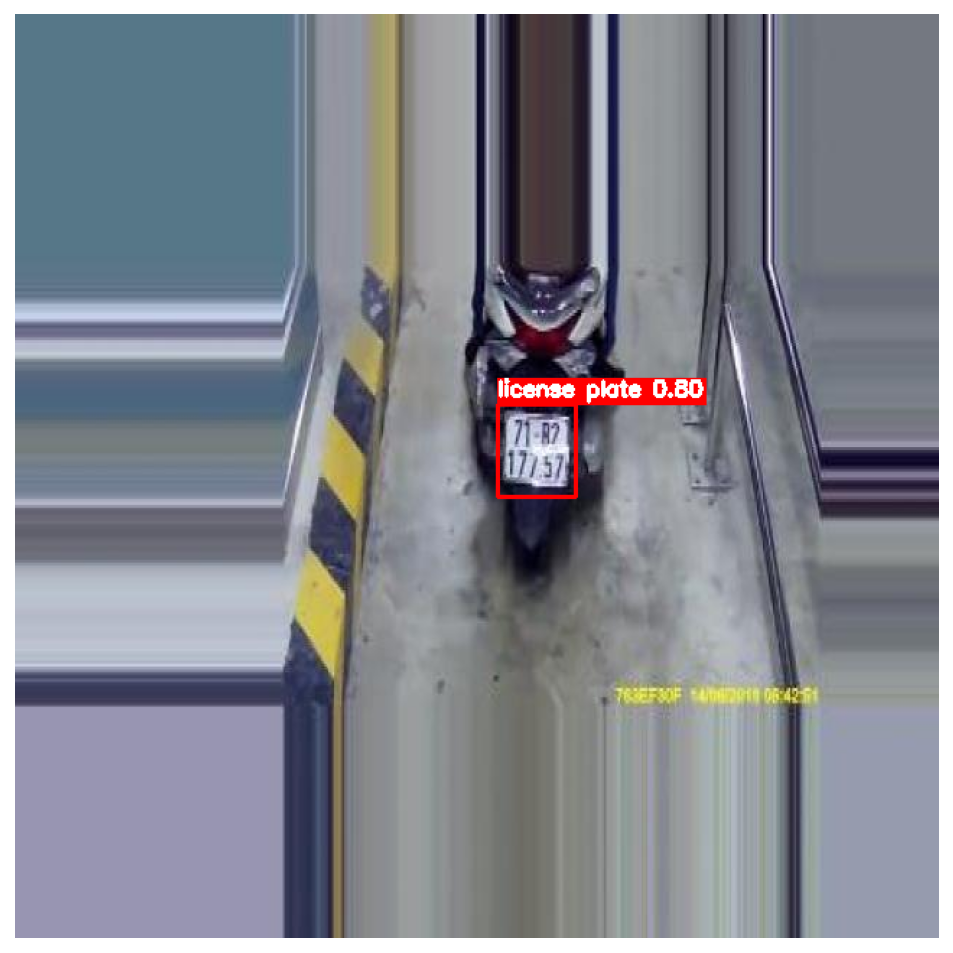

In [49]:
import random

image_dir = '/kaggle/input/licenseplate/test/images'
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]

# Choose a random image file
random_image_file = random.choice(image_files)

# Load the image using OpenCV
image = cv2.imread(random_image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = model(image)
for result in results:
    visual_prediction(result)

In [34]:
tide_predictions = []

# Assuming 'results' is your YOLO model's output object
for i, result in enumerate(results):
    # Convert boxes to TIDE format
    for box in result.boxes:
        xyxys = box.xyxy
        for coordinates in xyxys:
            x1, y1, x2, y2 = coordinates  # Modify as necessary to match the box attribute
            score = box.conf  # Confidence score
            class_id = box.cls  # Class ID
            image_id = i  # If you have unique image IDs, use those instead

            # Construct the prediction dictionary for TIDE
            tide_pred = {
                'image_id': image_id,  # You may need to map this to actual image IDs if necessary
                'category_id': class_id,  # Map this to COCO class IDs if necessary
                'bbox': [x1, y1, x2-x1, y2-y1],  # Convert to [x_min, y_min, width, height]
                'score': score
            }
            tide_predictions.append(tide_pred)
print(tide_predictions[0])

{'image_id': 0, 'category_id': tensor([1.], device='cuda:0'), 'bbox': [tensor(105.3397, device='cuda:0'), tensor(444.7195, device='cuda:0'), tensor(264.7584, device='cuda:0'), tensor(92.3470, device='cuda:0')], 'score': tensor([0.7614], device='cuda:0')}


In [14]:
tide_ground_truths = []

# List all text files in the directory
directory = '/kaggle/input/licenseplate/test/labels'
cnt = 0
for i, filename in enumerate(os.listdir(directory)):
    cnt += 1
    if filename.endswith('.txt'):
        filepath = os.path.join(directory, filename)
        image_id = i
        # Read annotation lines from the file
        with open(filepath, 'r') as file:
            for line in file:
                class_id, x_center, y_center, width, height = map(float, line.split())

                # Convert from normalized [0, 1] range to absolute coordinates
                # Assuming the image dimensions are known and stored in `image_width` and `image_height`
                x_min = (x_center - width / 2) * 640
                y_min = (y_center - height / 2) * 640
                abs_width = width * 640
                abs_height = height * 640

                # Create the ground truth dictionary for TIDE
                ground_truth = {
                    'image_id': image_id,
                    'category_id': int(class_id),
                    'bbox': [x_min, y_min, abs_width, abs_height]
                }

                tide_ground_truths.append(ground_truth)
print(len(tide_ground_truths))

909


In [15]:
def get_yolo_predictions(model, image_dir):
    predictions = []
    cnt = 0
    for i, filename in enumerate(os.listdir(image_dir)):
        cnt += 1
        # Get the image ID from the mapping
        image_id = i

        # Construct the full path to the image
        image_path = os.path.join(image_dir, filename)

        # Perform inference
        results = model(image_path, verbose = False)

        for result in results:
            for box in result.boxes:
                xyxys = box.xyxy
                for coordinates in xyxys:
                    x1, y1, x2, y2 = coordinates  # Modify as necessary to match the box attribute
                    score = box.conf  # Confidence score
                    class_id = box.cls  # Class ID
                    image_id = i  # If you have unique image IDs, use those instead

                    # Construct the prediction dictionary for TIDE
                    tide_pred = {
                        'image_id': image_id,  # You may need to map this to actual image IDs if necessary
                        'category_id': class_id.item(),  # Map this to COCO class IDs if necessary
                        'bbox': [x1.item(), y1.item(), (x2-x1).item(), (y2-y1).item()],  # Convert to [x_min, y_min, width, height]
                        'score': score.item(),
                        'filename': filename
                    }
                    predictions.append(tide_pred)
    print(cnt)
    return predictions

In [16]:
tide_predictions = get_yolo_predictions(model,'/kaggle/input/licenseplate/test/images')
print(len(tide_predictions))

887
951


In [17]:
!pip install tidecv

  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/ba/64/0451cf41a00fd5ac4501de4ea0e395b7d909e09d665e56890b5d3809ae26/pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 14.6 MB/s eta 0:00:00


In [18]:
import json
import os

# Replace these with the actual paths and values
gt_dir = '/kaggle/input/licenseplate/test/labels'
image_dir = '/kaggle/input/licenseplate/test/images'
output_json_path = 'ground_truths.json'

# Initialize the JSON structure
coco_format = {
    'images': [],
    'annotations': [],
    'categories': []
}

# Let's assume you already have a list of category names and their corresponding IDs
category_id_mapping = {'license plate': 1, 'lights': 0}  # etc.

# Add categories to COCO JSON
for category_name, category_id in category_id_mapping.items():
    coco_format['categories'].append({
        'id': category_id,
        'name': category_name,
        'supercategory': category_name
    })

# Populate images and annotations
annotation_id = 1
for i, filename in enumerate(os.listdir(image_dir)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_id = i
        image_path = os.path.join(image_dir, filename)
        
        # Add image information
        coco_format['images'].append({
            'id': image_id,
            'file_name': filename,
            'width': 640,  # Replace with actual image width
            'height': 640  # Replace with actual image height
        })

        # Corresponding ground truth file
        gt_filepath = os.path.join(gt_dir, filename.replace('jpg', 'txt').replace('txt', 'jpg', 1))
        if os.path.exists(gt_filepath):
            with open(gt_filepath, 'r') as f:
                for line in f:
                    class_id, x_center, y_center, bbox_width, bbox_height = [
                        float(x) for x in line.strip().split()
                    ]

                    # Convert to COCO format
                    x_min = (x_center - (bbox_width / 2)) * 640  # image width
                    y_min = (y_center - (bbox_height / 2)) * 640  # image height
                    width = bbox_width * 640  # image width
                    height = bbox_height * 640  # image height

                    # Add annotation information
                    coco_format['annotations'].append({
                        'id': annotation_id,
                        'image_id': image_id,
                        'category_id': int(class_id),
                        'bbox': [x_min, y_min, width, height],
                        'area': width * height,
                        'iscrowd': 0,
                        'segmentation': [[0 for i in range(640)] for i in range(640)]
                    })
                    annotation_id += 1
                    
# Write the COCO format JSON to a file
with open(output_json_path, 'w') as f:
    json.dump(coco_format, f, indent=2)


In [19]:
import json

# Giả sử `ground_truths` là danh sách các dictionaries chứa thông tin ground truth
# và `predictions` là danh sách các dictionaries chứa thông tin dự đoán.
# Các dictionaries này phải có định dạng phù hợp với COCO.

# Chuyển danh sách ground truths thành JSON
# with open('ground_truths.json', 'w') as f:
#     json.dump(tide_ground_truths, f)

# Chuyển danh sách predictions thành JSON
with open('predictions.json', 'w') as f:
    json.dump(tide_predictions, f)

In [20]:
print(len(tide_predictions))
print(len(coco_format['images']))

951
887


In [21]:
!pip install tidecv

In [22]:
from tidecv import TIDE
import tidecv.datasets as datasets

pred = datasets.COCOResult('/kaggle/working/predictions.json')
gt = datasets.COCO('/kaggle/working/ground_truths.json')

In [23]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Initialize COCO ground truth API
coco_gt = COCO('/kaggle/working/ground_truths.json')  # path to the JSON with ground truth annotations

# Initialize COCO predictions API
coco_dt = coco_gt.loadRes('/kaggle/working/predictions.json')  # path to the JSON with detection results

# Initialize COCOeval object
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')

# Evaluate on a subset of images by setting their ids
# If you want to evaluate on the entire validation set, you can omit this line
# coco_eval.params.imgIds = image_ids  # list of image ids to evaluate on

# Run evaluation
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=55.61s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.41s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.571
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.891
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.677
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.544
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.736
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.430
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.650
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

In [24]:

tide = TIDE()
# Run the evaluations on the standard COCO metrics 
tide.evaluate_range(gt, pred, mode=TIDE.BOX)

tide.summarize()

-- predictions --

bbox AP @ [50-95]: 57.05
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      89.12    88.63    88.60    83.23    79.39    67.74    42.24    24.04     7.28     0.26  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     0.00     3.79     0.00     0.39     0.78     4.92  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       4.94       5.40  



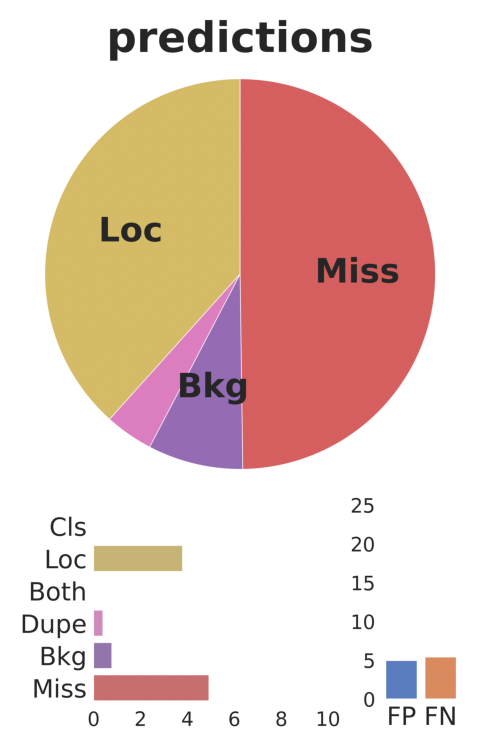

In [25]:
tide.plot()